# Canny Edge Detection

This is a demo of [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detector) using [OpenCV](https://opencv.org/).

## Step 1: Noise Reduction

The first step is to apply a Gaussian filter to smooth the image in order to remove the noise. The resulting image is less sensitive to noise and more suitable for edge detection.

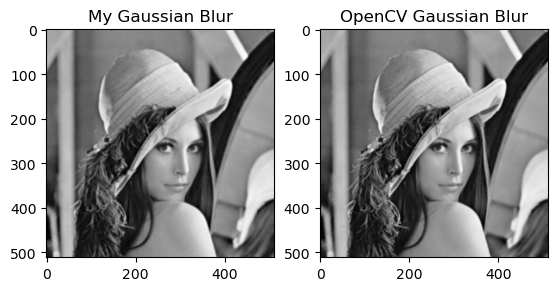

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Read the image
img = cv2.imread("images/lena.png", 0)


def gaussian_blur(img):
    # Use Gaussian Blur to remove noise
    # 5x5 kernel
    gauss_mask = (
        np.array(
            [
                [2, 4, 5, 4, 2],
                [4, 9, 12, 9, 4],
                [5, 12, 15, 12, 5],
                [4, 9, 12, 9, 4],
                [2, 4, 5, 4, 2],
            ]
        )
        / 159
    )

    # Since the kernel is 2 more than the image, we pad the image with 2 using reflection
    padded = np.pad(img, 2, mode="reflect")

    # Starting from the first non-padded pixel, we convolve the kernel with the image
    # and store the result in the output image
    out = convolve2d(padded, gauss_mask, mode="valid")

    # Convert the output image to uint8
    return out


my_blur = gaussian_blur(img)
opencv_blur = cv2.GaussianBlur(img, (5, 5), 1)

# Save my result
cv2.imwrite("images/canny/my_blur.png", my_blur)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(my_blur.astype(np.uint8), cmap="gray")
plt.title("My Gaussian Blur")

plt.subplot(132)
plt.imshow(opencv_blur, cmap="gray")
plt.title("OpenCV Gaussian Blur")

plt.show()


## Step 2: Finding Intensity Gradient of the Image

The second step is to find the intensity gradient of the image. The image is convolved with a filter (e.g., Sobel) in both the horizontal and vertical directions. From this, we can find the edge gradient and direction for each pixel as follows:

$$
\begin{align}
G &= \sqrt{G_x^2 + G_y^2} \\
\theta &= \arctan{\frac{G_y}{G_x}}
\end{align}
$$

In [ ]:
def sobel(image):
    # Sobel operator in x direction
    sobel_x = [
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ]
    sobel_x = np.array(sobel_x, dtype=np.float64)

    # Sobel operator in y direction
    sobel_y = [
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1],
    ]
    sobel_y = np.array(sobel_y, dtype=np.float64)

    # Pad the image with 1
    padded = np.pad(image, 1, mode="reflect")

    # Convolve the image with the sobel operators using 64-bit floats

    dx = convolve2d(padded, sobel_x, mode="valid")
    dy = convolve2d(padded, sobel_y, mode="valid")

    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(dx**2 + dy**2)

    # Compute the direction of the gradient
    gradient_direction = np.arctan2(dy, dx)

    return gradient_magnitude, gradient_direction


def sobel_opencv(image):
    # Compute the gradient in x direction
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

    # Compute the gradient in y direction
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(dx**2 + dy**2)

    # Normalize the gradient magnitude
    # gradient_magnitude = np.uint8(gradient_magnitude * 255 / np.max(gradient_magnitude))

    # Compute the direction of the gradient
    gradient_direction = np.arctan2(dy, dx)

    return gradient_magnitude, gradient_direction


my_sobel, my_direction = sobel(opencv_blur)
opencv_sobel, opencv_direction = sobel_opencv(opencv_blur)

# Save my result
cv2.imwrite("images/canny/my_sobel.png", my_sobel)


# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(my_sobel, cmap="gray")
plt.title("My Sobel")

plt.subplot(132)
plt.imshow(opencv_sobel, cmap="gray")
plt.title("OpenCV Sobel")

plt.show()


## Step 3: Non-maximum Suppression

After getting the gradient magnitude and direction, a full scan of the image is done to remove any unwanted pixels which may not constitute the edge. For this, we check every pixel to see if it is a local maximum in its neighborhood in the direction of the gradient.

In [ ]:
def non_max_suppresion(m, d):
    # Round the gradient direction to 0, 45, 90, or 135 degrees
    deg = np.rad2deg(d)
    deg[deg < 0] += 180
    deg = np.round(deg / 45) * 45

    # Create a new image of zeros with the same shape as the original image
    new_image = np.zeros_like(m)

    count = 0

    h, w = m.shape
    # Iterate over the image pixels
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            direction = deg[i, j]

            if direction == 0 or direction == 180:
                is_max = m[i, j] >= m[i, j - 1] and m[i, j] >= m[i, j + 1]
            elif direction == 45:
                is_max = m[i, j] >= m[i - 1, j + 1] and m[i, j] >= m[i + 1, j - 1]
            elif direction == 90:
                is_max = m[i, j] >= m[i - 1, j] and m[i, j] >= m[i + 1, j]
            elif direction == 135:
                is_max = m[i, j] >= m[i - 1, j - 1] and m[i, j] >= m[i + 1, j + 1]

            count += is_max

            # Set the pixel to 0 if it is not a maximum
            new_image[i, j] = m[i, j] * is_max

    print(count)

    return new_image


def non_max_suppresion_with_interpolation(m, d):
    deg = np.copy(d)
    deg[deg < 0] += np.pi

    new_image = np.zeros_like(m)

    count = 0

    h, w = m.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            direction = deg[i, j]

            # if direction equals 0
            if direction == 0:
                is_max = m[i, j] >= m[i, j - 1] and m[i, j] >= m[i, j + 1]
            # if direction belongs to (0, 45]
            elif 0 < direction <= np.pi / 4:
                r = direction
                x = (1 - np.tan(r)) * m[i, j + 1] + np.tan(r) * m[i - 1, j + 1]
                y = (1 - np.tan(r)) * m[i, j - 1] + np.tan(r) * m[i + 1, j - 1]
                is_max = m[i, j] >= x and m[i, j] >= y
            # if direction belongs to (45, 90)
            elif np.pi / 4 < direction < np.pi / 2:
                r = np.pi / 2 - direction
                x = (1 - np.tan(r)) * m[i - 1, j] + np.tan(r) * m[i - 1, j + 1]
                y = (1 - np.tan(r)) * m[i + 1, j] + np.tan(r) * m[i + 1, j - 1]
                is_max = m[i, j] >= x and m[i, j] >= y
            # if direction equals 90
            elif direction == np.pi / 2:
                is_max = m[i, j] >= m[i - 1, j] and m[i, j] >= m[i + 1, j]
            # if direction belongs to (90, 135)
            elif np.pi / 2 < direction < 3 * np.pi / 4:
                r = direction - np.pi / 2
                x = (1 - np.tan(r)) * m[i - 1, j] + np.tan(r) * m[i - 1, j - 1]
                y = (1 - np.tan(r)) * m[i + 1, j] + np.tan(r) * m[i + 1, j + 1]
                is_max = m[i, j] >= x and m[i, j] >= y
            # if direction belongs to [135, 180)
            elif 3 * np.pi / 4 <= direction < np.pi:
                r = np.pi - direction
                x = (1 - np.tan(r)) * m[i, j - 1] + np.tan(r) * m[i - 1, j - 1]
                y = (1 - np.tan(r)) * m[i, j + 1] + np.tan(r) * m[i + 1, j + 1]
                is_max = m[i, j] >= x and m[i, j] >= y
            # if direction equals 180
            elif direction == np.pi:
                is_max = m[i, j] >= m[i, j - 1] and m[i, j] >= m[i, j + 1]

            count += is_max

            new_image[i, j] = m[i, j] * is_max

    print(count)

    return new_image


# Perform NMS on the image
my_nms = non_max_suppresion(opencv_sobel, opencv_direction)
my_nms_interpolation = non_max_suppresion_with_interpolation(
    opencv_sobel, opencv_direction
)

# Save my result
cv2.imwrite("images/canny/my_nms.png", my_nms)
cv2.imwrite("images/canny/my_nms_interpolation.png", my_nms_interpolation)

# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(my_nms, cmap="gray")
plt.title("NMS without Interpolation")

plt.subplot(132)
plt.imshow(my_nms_interpolation, cmap="gray")
plt.title("NMS with Interpolation")

plt.show()


## Step 4: Hysteresis Thresholding

This stage decides which edges are really edges and which are not. For this, we need two threshold values, `minVal` and `maxVal`. Any edges with intensity gradient more than `maxVal` are sure to be edges and those below `minVal` are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded.

In [ ]:
def double_threshold(m, low_threshold, high_threshold):
    # Threshold is normalized to the max value of the image
    max_val = np.max(m)

    # Normalize the thresholds
    low_threshold = low_threshold / 255 * max_val
    high_threshold = high_threshold / 255 * max_val

    strong_edges = np.zeros_like(m)
    weak_edges = np.zeros_like(m)

    # Get the strong edges
    strong_edges[m >= high_threshold] = 1

    # Get the weak edges
    weak_edges[np.logical_and(m >= low_threshold, m < high_threshold)] = 1

    return strong_edges, weak_edges


# Perform double thresholding
strong1, weak1 = double_threshold(my_nms, 20, 40)
strong2, weak2 = double_threshold(my_nms_interpolation, 20, 40)

my_strong1 = strong1 * 255
my_weak1 = weak1 * 100
my_dh1 = my_strong1 + my_weak1

my_strong2 = strong2 * 255
my_weak2 = weak2 * 100
my_dh2 = my_strong2 + my_weak2

# Save my result
cv2.imwrite("images/canny/my_dh1.png", my_dh1)
cv2.imwrite("images/canny/my_dh2.png", my_dh2)


# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(my_dh1, cmap="gray")
plt.title("DH without Interpolation")

plt.subplot(122)
plt.imshow(my_dh2, cmap="gray")
plt.title("DH with Interpolation")

plt.show()


## Step 5: Edge Tracking by Hysteresis

A pixel is considered to belong to an edge if it is connected to a pixel that is already part of an edge.

In [ ]:
def hysteresis(weak, strong):
    while True:
        # Get the indices of the weak edges
        indices = np.argwhere(weak > 0)
        found = False
        # Iterate over the weak edges
        for i, j in indices:
            neighborhood = strong[i - 1 : i + 2, j - 1 : j + 2]
            if np.any(neighborhood > 0):
                found = True
                # Set the weak edge to a strong edge
                weak[i, j] = 0
                strong[i, j] = 1

        # If there are no new strong edges, we are done
        if not found:
            break

    strong[strong > 0] = 255

    return strong


# Perform edge tracking by hysteresis
my_edge_1 = hysteresis(my_weak1, my_strong1)
my_edge_2 = hysteresis(my_weak2, my_strong2)

# Save my result
cv2.imwrite("images/canny/my_edge_1.png", my_edge_1)
cv2.imwrite("images/canny/my_edge_2.png", my_edge_2)


# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(my_edge_1, cmap="gray")
plt.title("Without Interpolation")

plt.subplot(122)
plt.imshow(my_edge_2, cmap="gray")
plt.title("With Interpolation")

plt.show()


In [ ]:
import my_canny
import cv2

sample = cv2.imread("images/engine.png", 0)

for l_thres in range(1, 81):
    h_thres = l_thres * 2
    my_edge = my_canny.canny(sample, l_thres, h_thres)
    cv2.imwrite("images/canny/engine/x2/my_edge_" + str(l_thres) + "_x2.png", my_edge)

for l_thres in range(1, 81):
    h_thres = l_thres * 3
    my_edge = my_canny.canny(sample, l_thres, h_thres)
    cv2.imwrite("images/canny/engine/x3/my_edge_" + str(l_thres) + "_x3.png", my_edge)


# Car Plate Detection

This is a demo of car plate detection using Canny edge detection.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import my_canny

sample = cv2.imread("images/plate-1.png")

In [ ]:
# Canny edge detection
edges = cv2.Canny(sample, 300, 500)

# My Canny edge detection
my_edges = my_canny.canny(sample, 50, 110)

# Plot the results
plt.imshow(my_edges, cmap="gray")
plt.show()


In [ ]:
element_x = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 4))
element_y = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 20))

# Perform morphological operations
img1 = cv2.dilate(my_edges, element_x, iterations=2)

plt.imshow(img1, cmap="gray")
plt.show()

In [ ]:
img2 = cv2.erode(img1, element_x, iterations=6)

plt.imshow(img2, cmap="gray")
plt.show()

In [ ]:
img3 = cv2.dilate(img2, element_x, iterations=4)

plt.imshow(img3, cmap="gray")
plt.show()

In [ ]:
img4 = cv2.erode(img3, element_y, iterations=2)

plt.imshow(img4, cmap="gray")
plt.show()

In [ ]:
img5 = cv2.dilate(img4, element_y, iterations=3)

plt.imshow(img5, cmap="gray")
plt.show()

In [ ]:
blur = cv2.medianBlur(img5, 15)

plt.imshow(blur, cmap="gray")
plt.show()

In [ ]:
contours, hierarchy = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    r = w / h
    print(r)
    if 2 < r < 5:
        cv2.rectangle(sample, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Save the result
cv2.imwrite("images/plate-1-result.png", sample)